In [1]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 12.3 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install catboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import catboost

from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

random_state = 25

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data

## Base

### Base dataset

In [4]:
# загрузка данных (анонимизированный набор товаров)
df_base = pd.read_csv("/kaggle/input/datama2/base.csv", index_col=0)
df_base.head()

0          1          2          3           4           5  \
Id                                                                            
0-base -115.083890  11.152912 -64.426760 -118.88089  216.482440 -104.698060   
1-base  -34.562202  13.332763 -69.787610 -166.53348   57.680607  -86.098370   
2-base  -54.233746   6.379371 -29.210136 -133.41383  150.895830  -99.435326   
3-base  -87.520130   4.037884 -87.803030 -185.06763   76.369540  -58.985165   
4-base  -72.743850   6.522049  43.671265 -140.60803    5.820023 -112.074080   

                 6          7           8           9  ...          62  \
Id                                                     ...               
0-base -469.070588  44.348083  120.915344  181.449700  ...  -42.808693   
1-base  -85.076666 -35.637436  119.718636  195.234190  ... -117.767525   
2-base   52.554795  62.381706  128.951450  164.381470  ...  -76.397800   
3-base -383.182845 -33.611237  122.031910  136.233580  ...  -70.647940   
4-base -397.711282  45.182500  122.167180  112.119064  ...  -57.199104   

               63         64          65        66         67          68  \
Id                                                                          
0-base  38.800827 -151.76218  -74.389090  63.66634  -4.703861   92.933610   
1-base  41.100000 -157.82940  -94.446806  68.20211  24.346846  179.937930   
2-base  46.011803 -207.14442  127.325570  65.56618  66.325680   81.073490   
3-base  -6.358921 -147.20105  -37.692750  66.20289 -20.566910  137.206940   
4-base  56.642403 -159.35184   85.944724  66.76632  -2.505783   65.315285   

                69           70         71  
Id                                          
0-base  115.269190  -112.756640 -60.830353  
1-base  116.834000   -84.888941 -59.524610  
2-base  116.594154 -1074.464888 -32.527206  
3-base  117.474100 -1074.464888 -72.915490  
4-base  135.051590 -1074.464888   0.319401  

[5 rows x 72 columns]

In [5]:
df_base.shape

(2918139, 72)

In [6]:
# краткая информация о данных
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


In [7]:
# краткая информация о данных
df_base.describe()

0             1             2             3             4  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -8.622947e+01  8.080077e+00 -4.458080e+01 -1.466350e+02  1.113166e+02   
std    2.489132e+01  4.953387e+00  3.863166e+01  1.984480e+01  4.634809e+01   
min   -1.994687e+02 -1.391461e+01 -2.400734e+02 -2.326671e+02 -1.055830e+02   
25%   -1.030654e+02  4.708491e+00 -6.955949e+01 -1.599051e+02  8.050795e+01   
50%   -8.623150e+01  8.038950e+00 -4.381661e+01 -1.467768e+02  1.118730e+02   
75%   -6.925658e+01  1.147007e+01 -1.962527e+01 -1.333277e+02  1.423743e+02   
max    2.151555e+01  2.993721e+01  1.609372e+02 -5.137478e+01  3.196645e+02   

                  5             6             7             8             9  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean  -7.199138e+01 -3.922239e+02  2.035283e+01  1.236842e+02  1.244581e+02   
std    2.818607e+01  2.716550e+02  6.421638e+01  6.356109e+00  6.443058e+01   
min   -2.110086e+02 -7.914699e+02 -3.018597e+02  9.315305e+01 -1.738719e+02   
25%   -9.137994e+01 -6.293318e+02 -2.222147e+01  1.194840e+02  8.176751e+01   
50%   -7.192230e+01 -4.222016e+02  2.080477e+01  1.238923e+02  1.234977e+02   
75%   -5.244111e+01 -1.566686e+02  6.391821e+01  1.279705e+02  1.672206e+02   
max    5.880624e+01  1.096325e+02  3.412282e+02  1.522612e+02  4.275421e+02   

       ...            62            63            64            65  \
count  ...  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean   ... -7.902286e+01  3.329735e+01 -1.547962e+02  1.415132e+01   
std    ...  3.045642e+01  2.888603e+01  4.122929e+01  9.895115e+01   
min    ... -2.205662e+02 -8.850774e+01 -3.539028e+02 -1.575944e+02   
25%    ... -9.876390e+01  1.698862e+01 -1.807799e+02 -7.130038e+01   
50%    ... -7.848812e+01  3.471502e+01 -1.539773e+02  1.382693e+01   
75%    ... -5.853355e+01  5.216429e+01 -1.273405e+02  9.966753e+01   
max    ...  6.017411e+01  1.541678e+02  2.436099e+01  1.850981e+02   

                 66            67            68            69            70  \
count  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06  2.918139e+06   
mean   6.779167e+01  2.354490e+01  7.495930e+01  1.155667e+02 -7.993390e+02   
std    1.823356e+00  5.534224e+01  6.134500e+01  2.117518e+01  3.854131e+02   
min    5.950944e+01 -2.331382e+02 -2.036016e+02  1.572448e+01 -1.297931e+03   
25%    6.658096e+01 -1.251624e+01  3.377574e+01  1.016867e+02 -1.074465e+03   
50%    6.781458e+01  2.341649e+01  7.492997e+01  1.160244e+02 -1.074465e+03   
75%    6.902666e+01  5.975511e+01  1.158760e+02  1.295524e+02 -5.057445e+02   
max    7.571203e+01  3.148988e+02  3.395738e+02  2.147063e+02  9.877081e+01   

                 71  
count  2.918139e+06  
mean  -4.779125e+01  
std    4.174802e+01  
min   -2.267801e+02  
25%   -7.566641e+01  
50%   -4.859196e+01  
75%   -1.971424e+01  
max    1.269732e+02  

[8 rows x 72 columns]

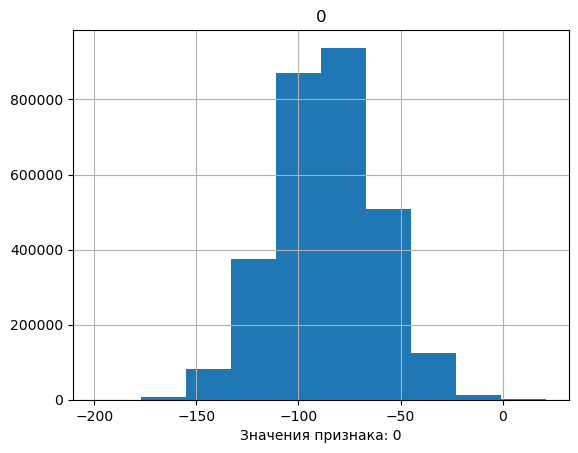

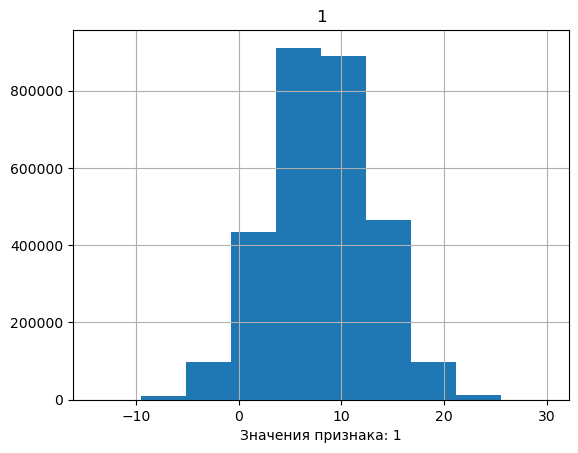

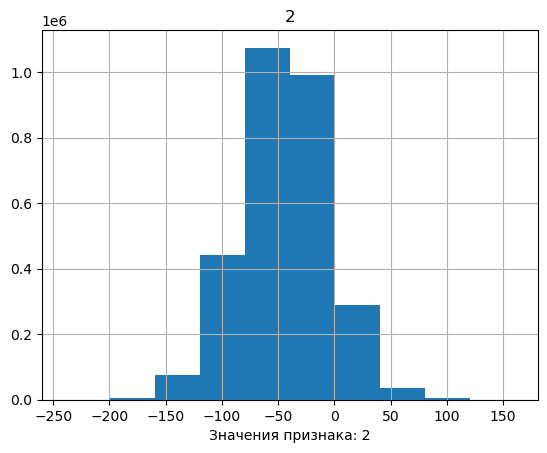

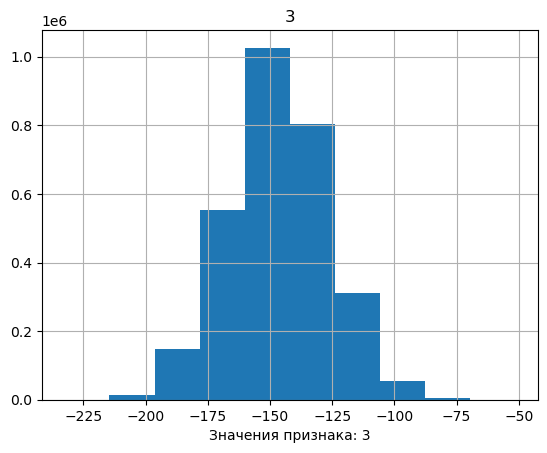

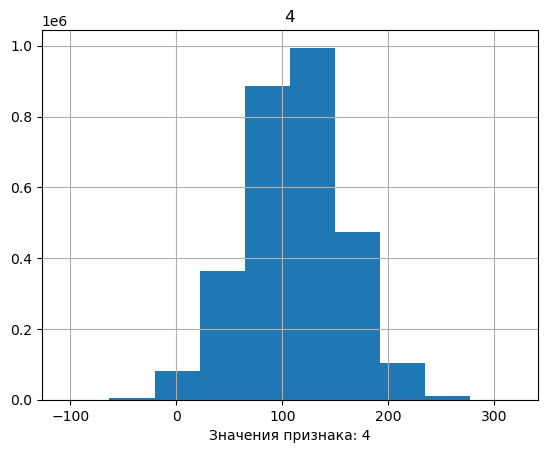

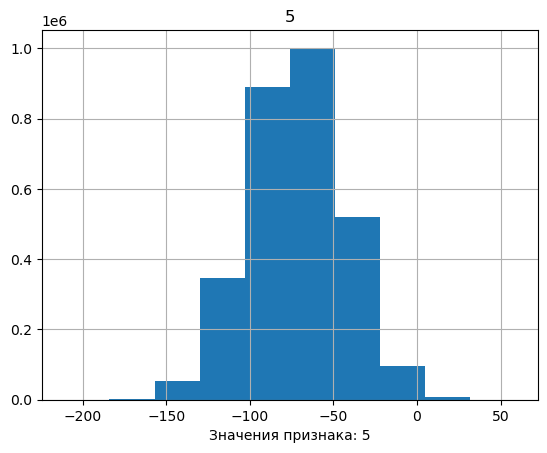

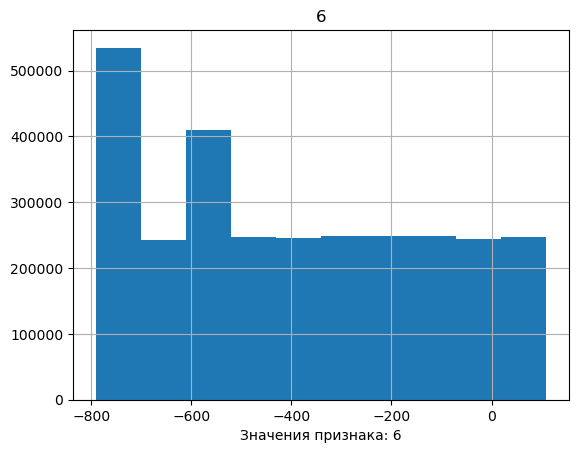

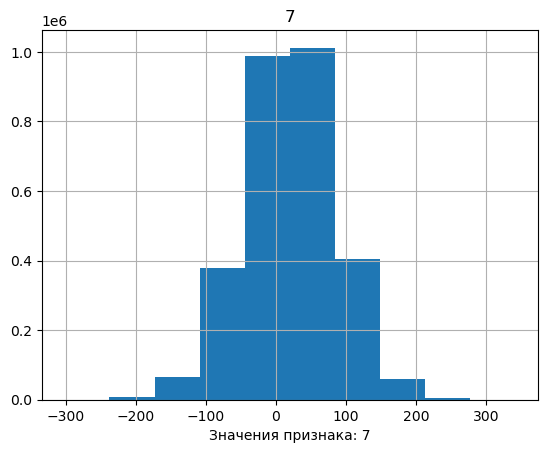

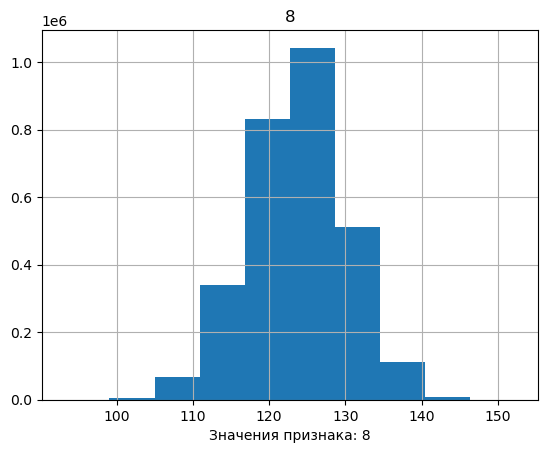

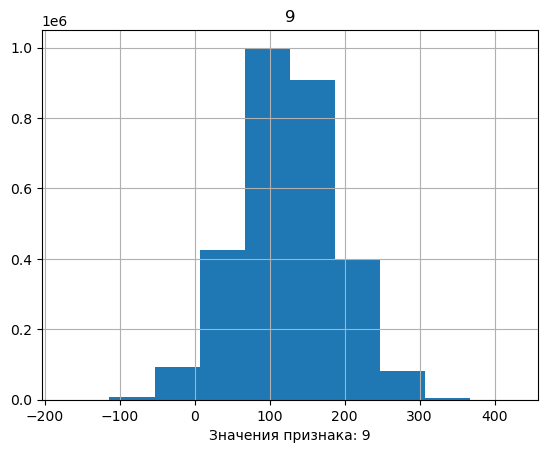

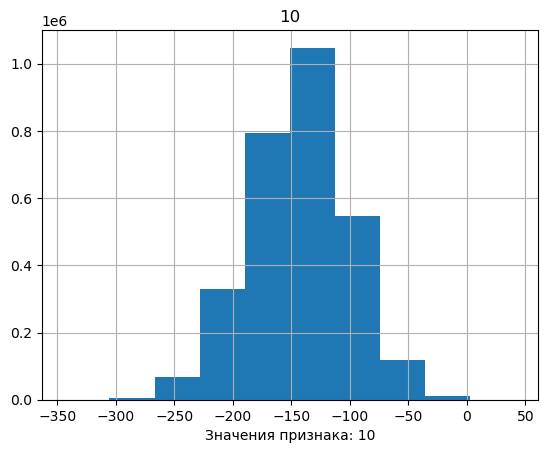

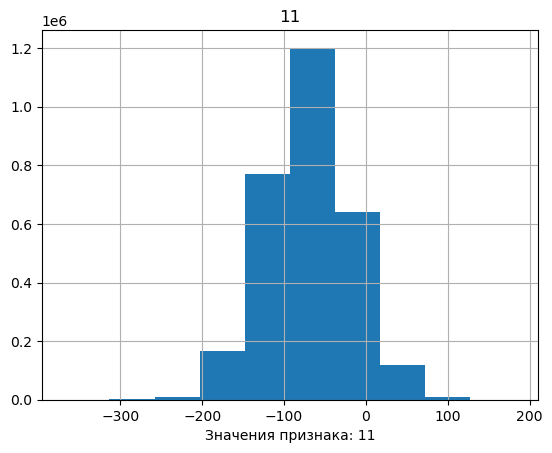

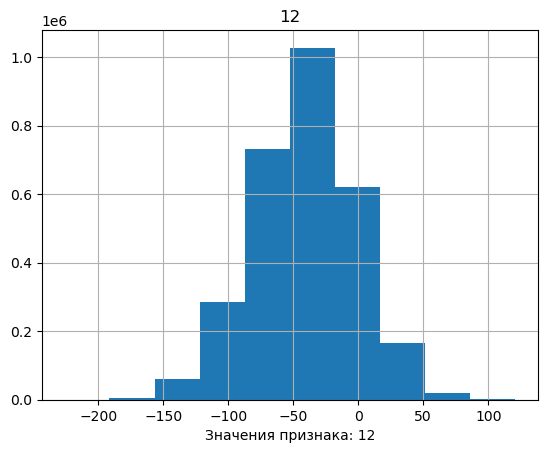

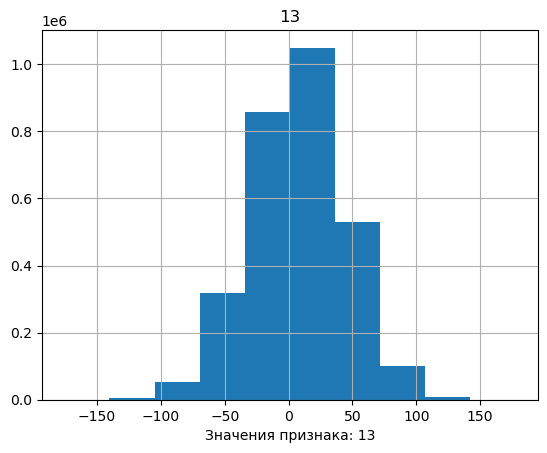

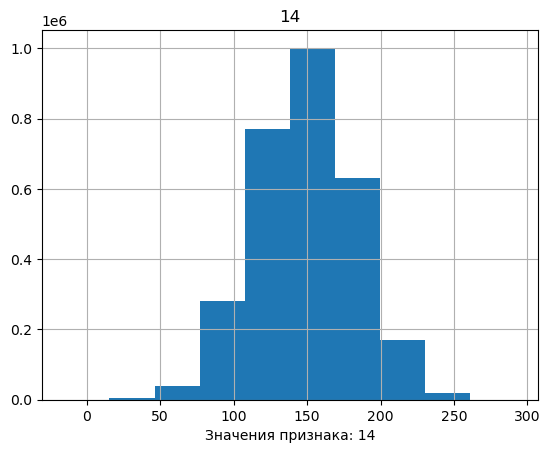

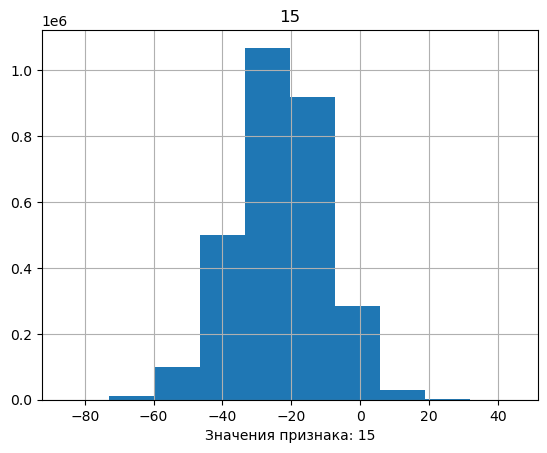

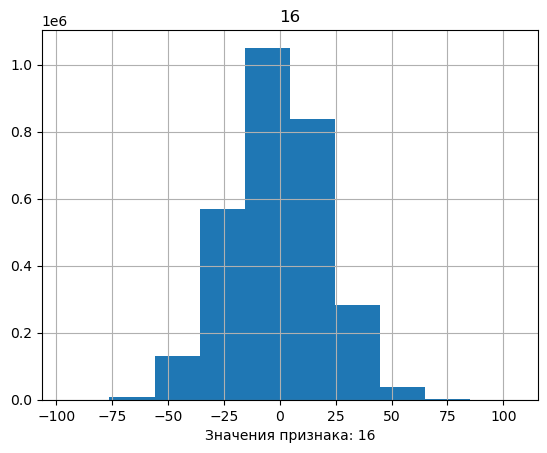

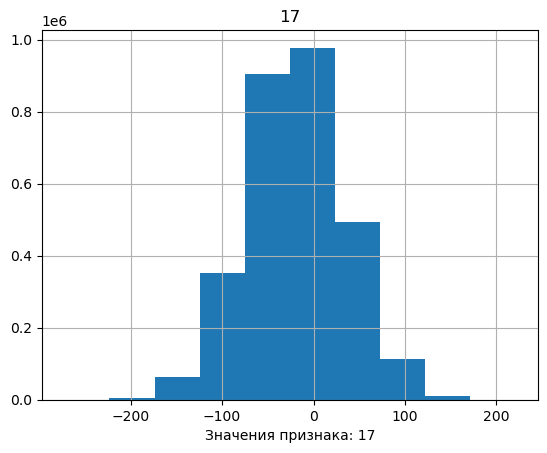

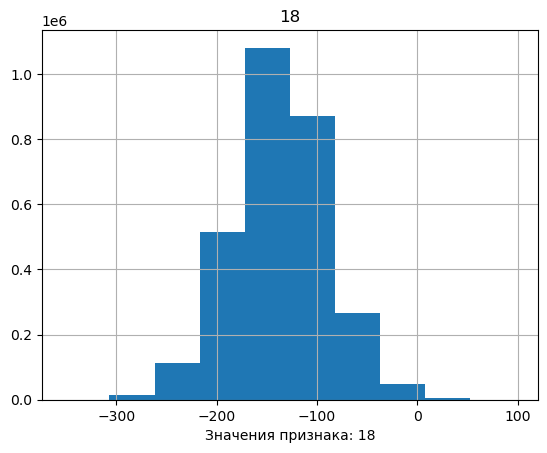

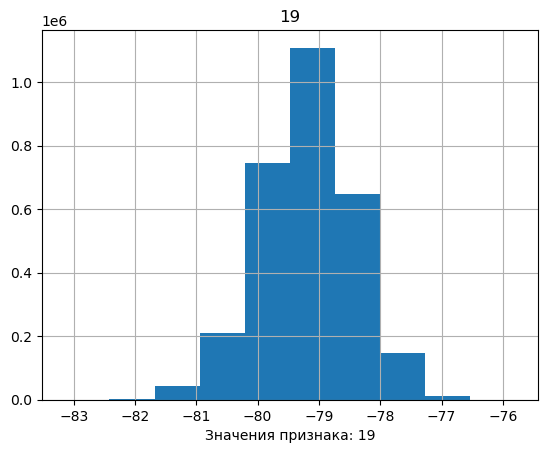

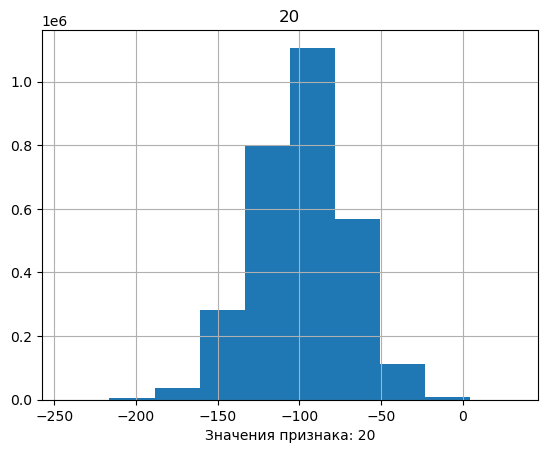

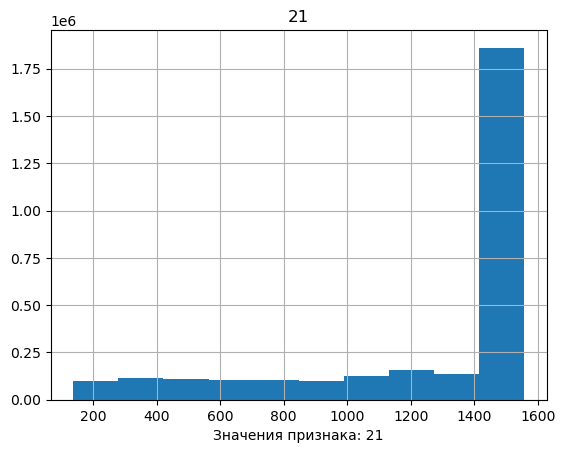

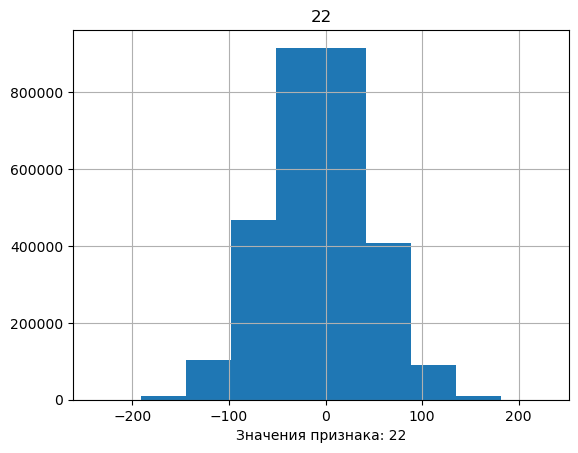

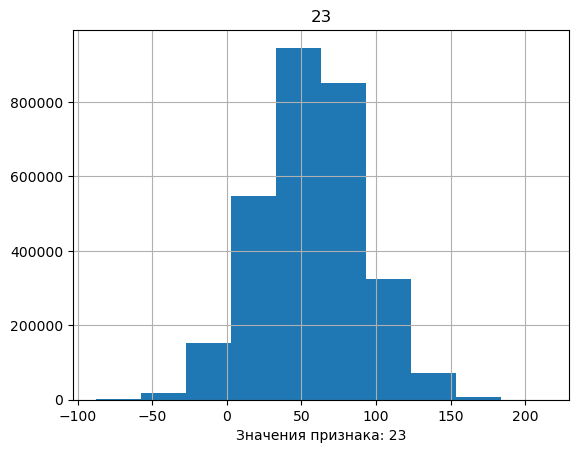

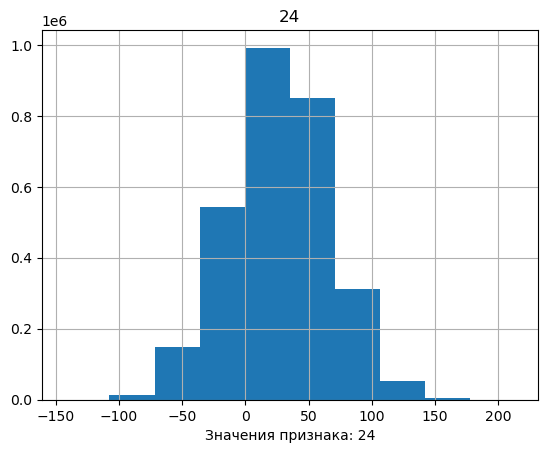

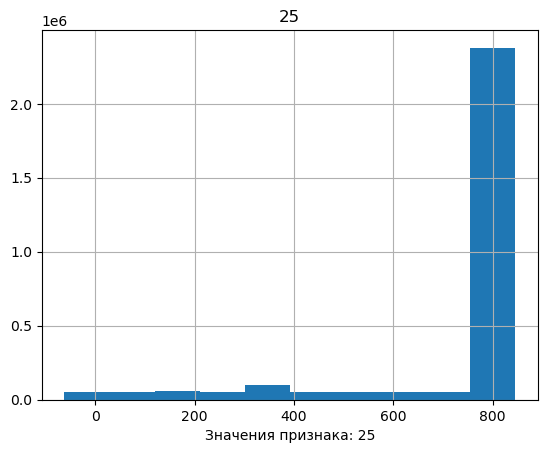

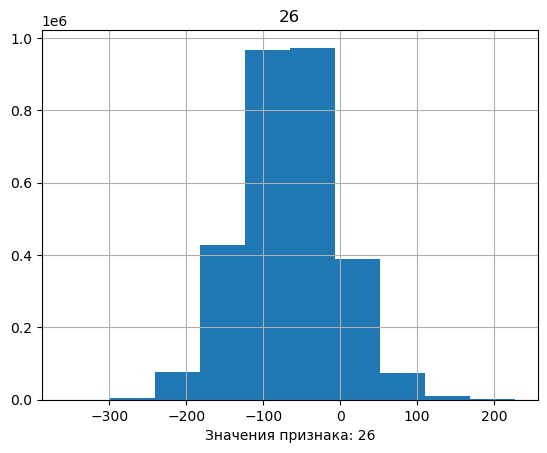

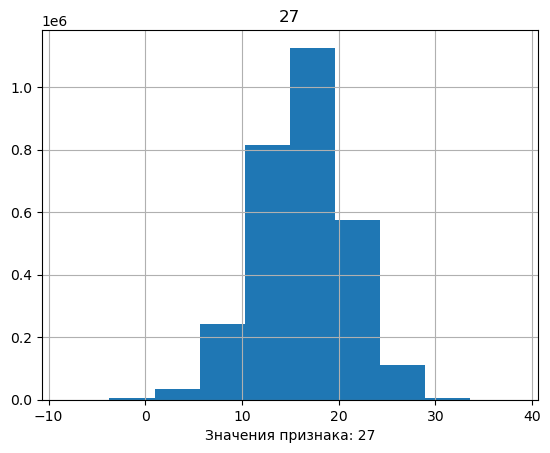

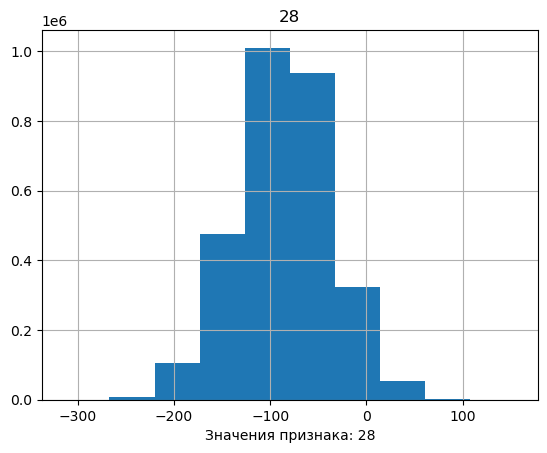

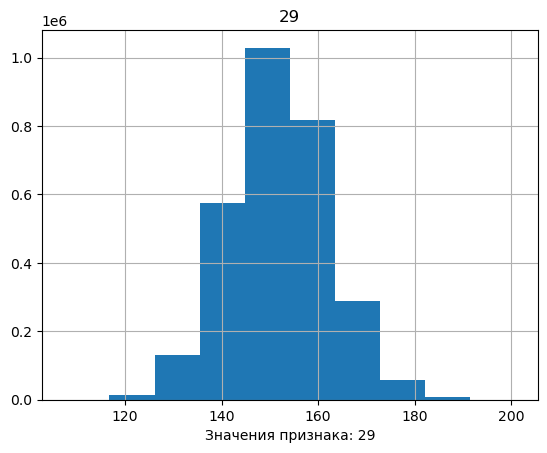

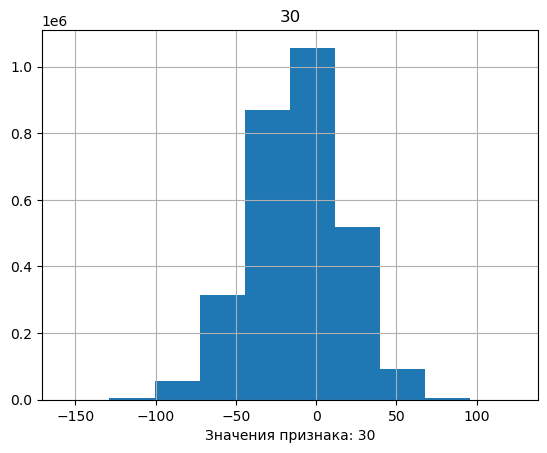

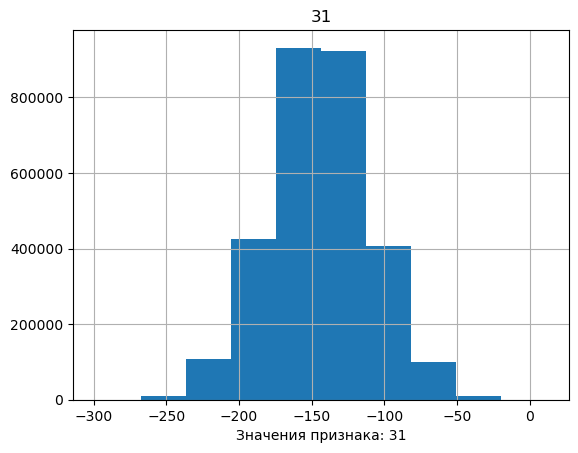

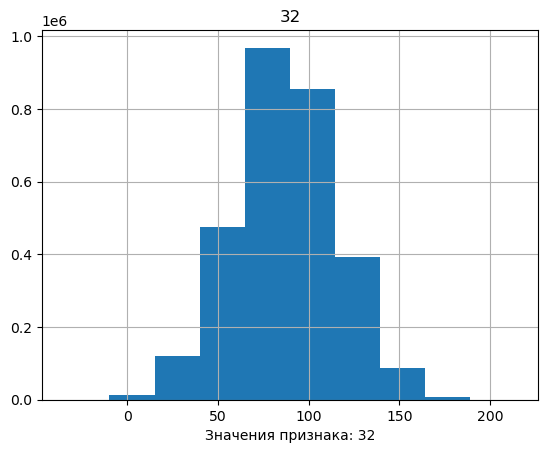

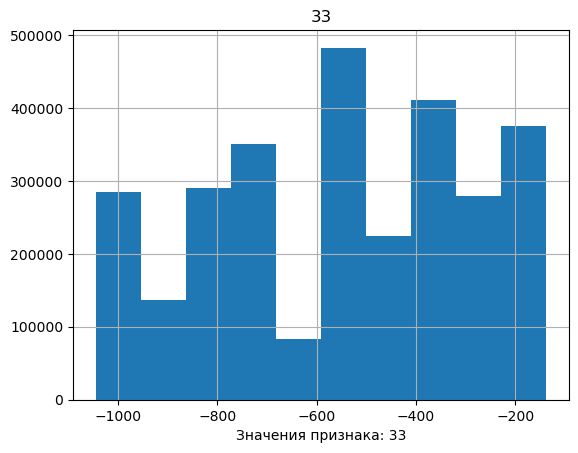

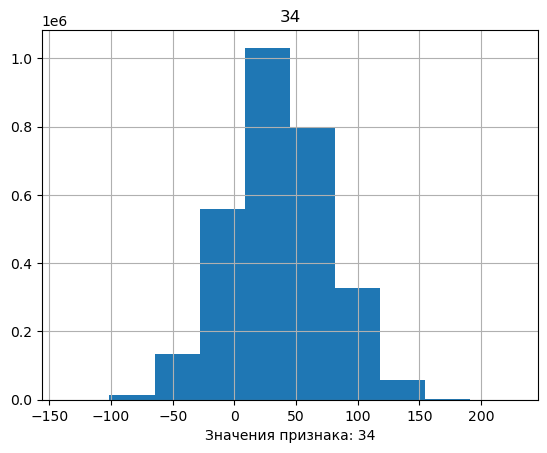

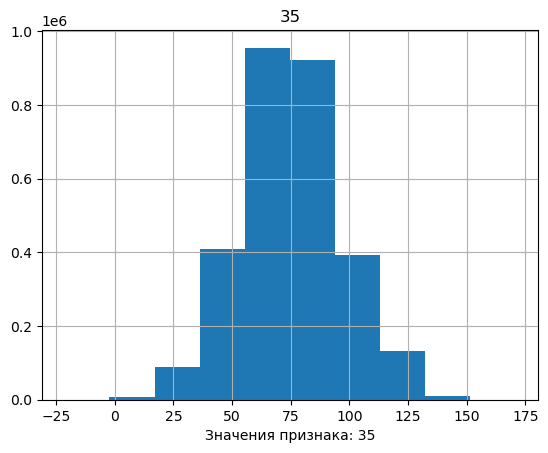

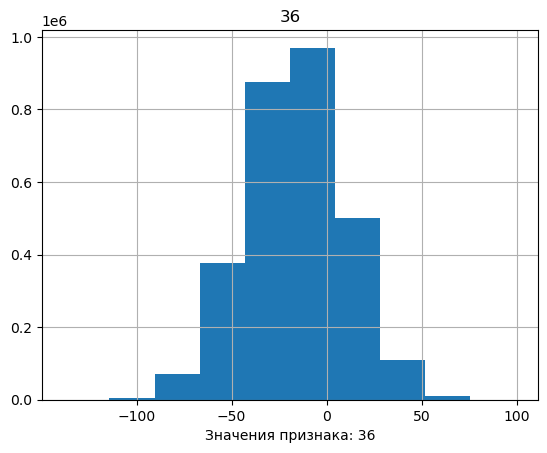

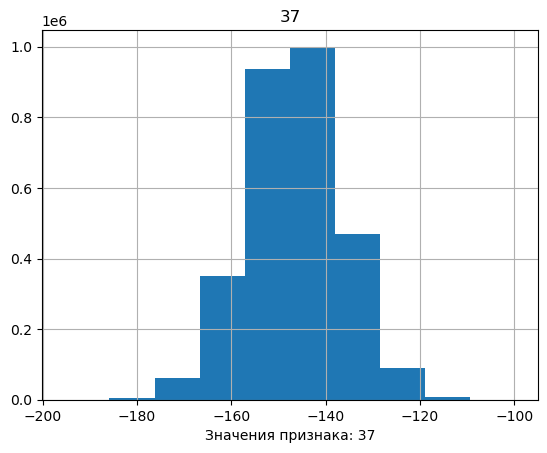

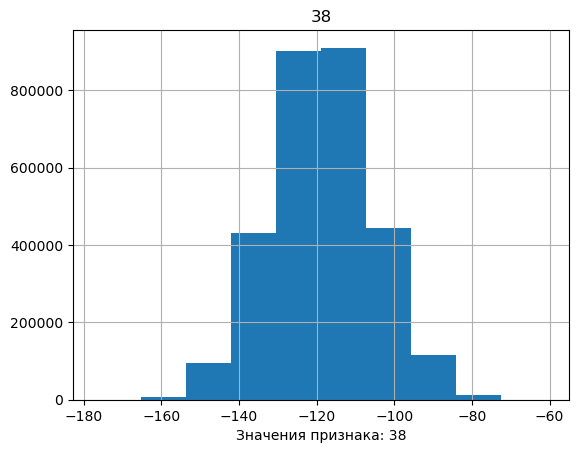

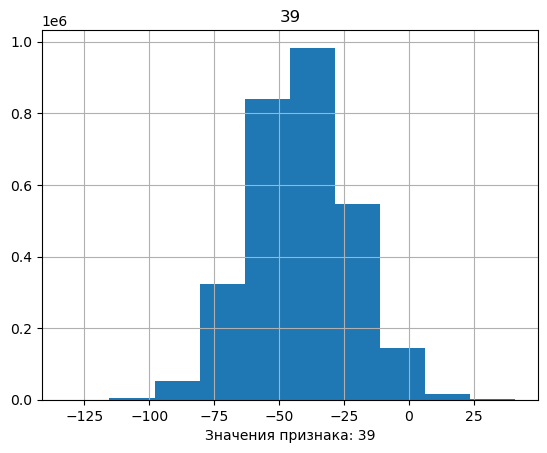

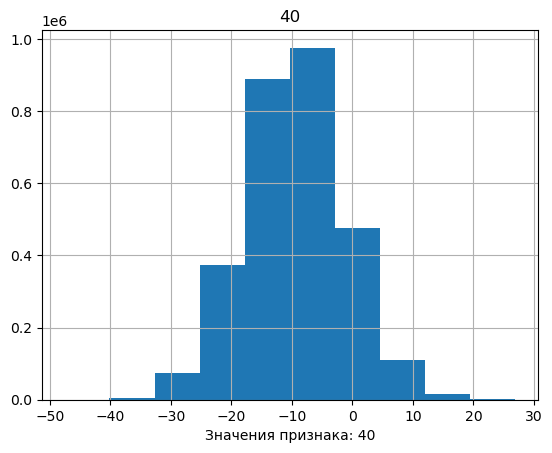

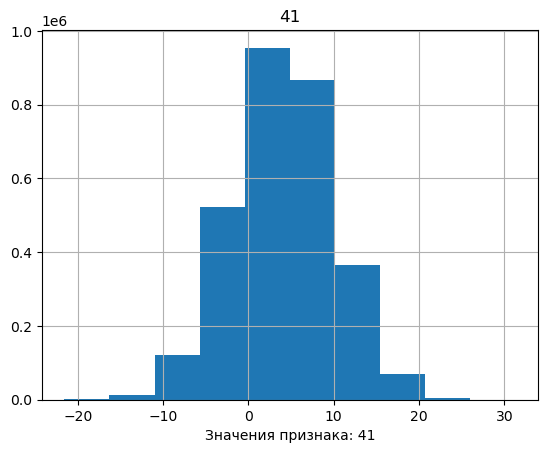

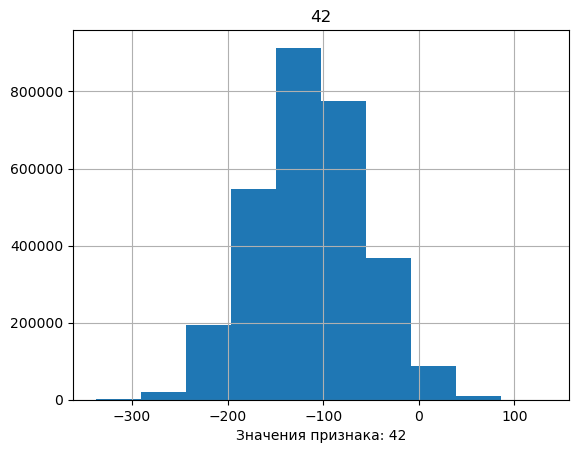

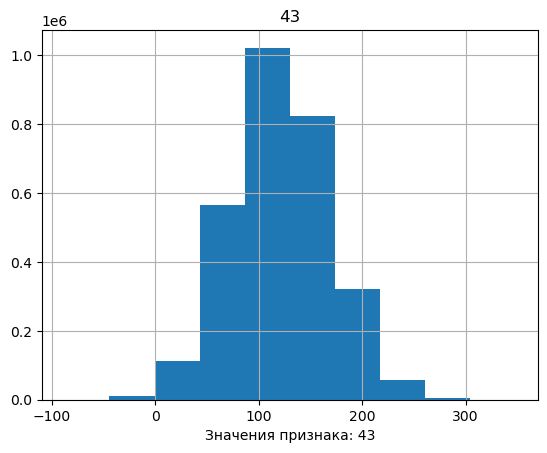

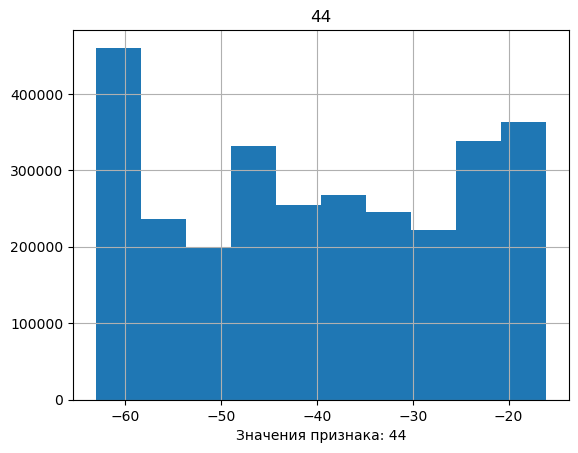

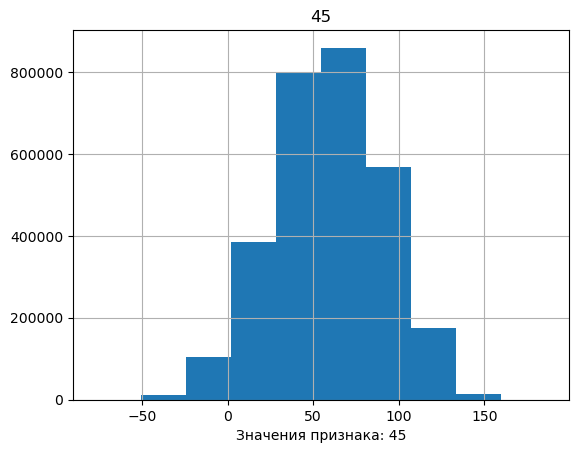

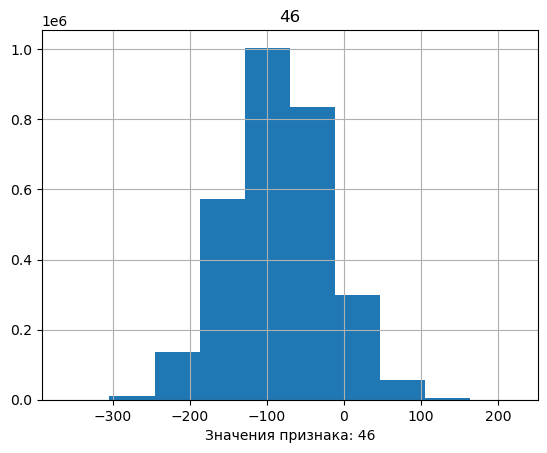

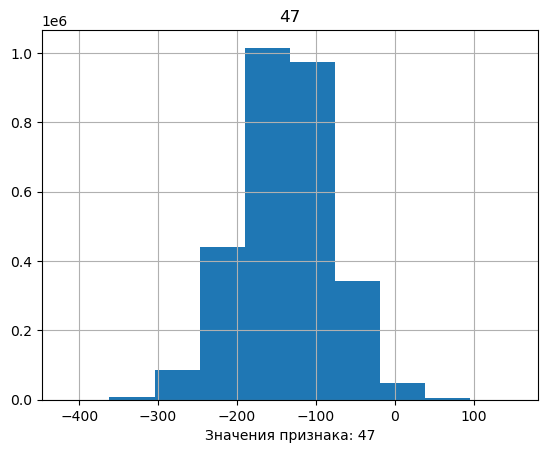

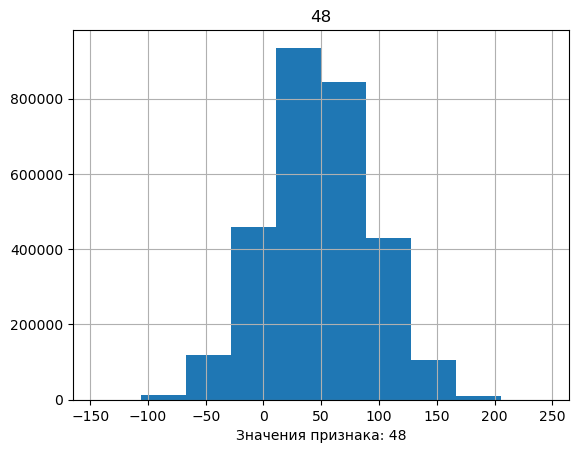

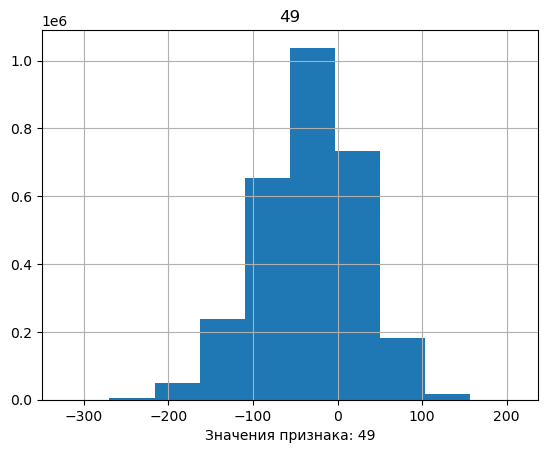

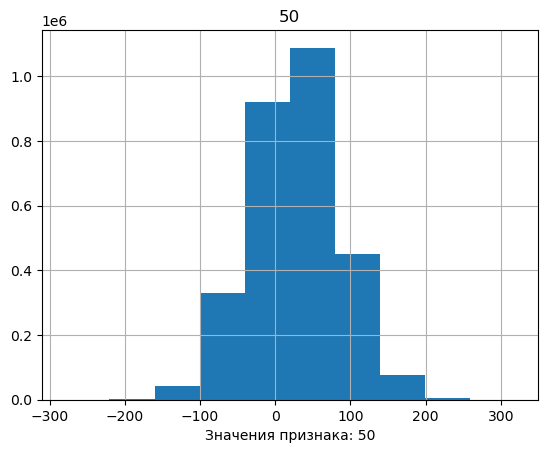

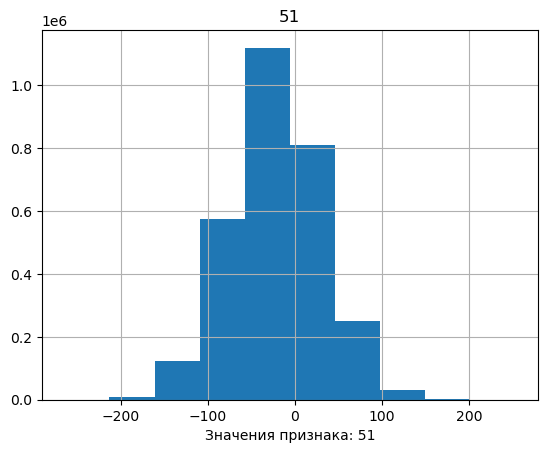

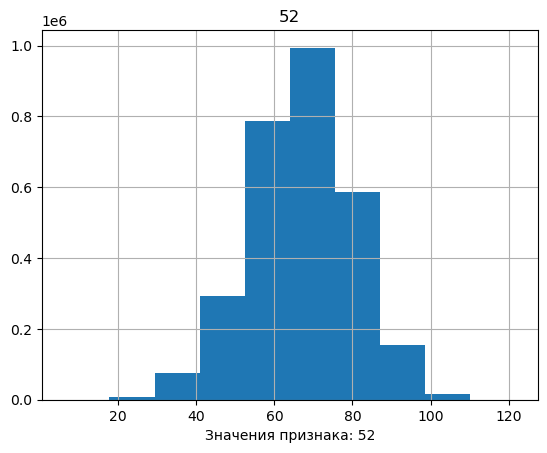

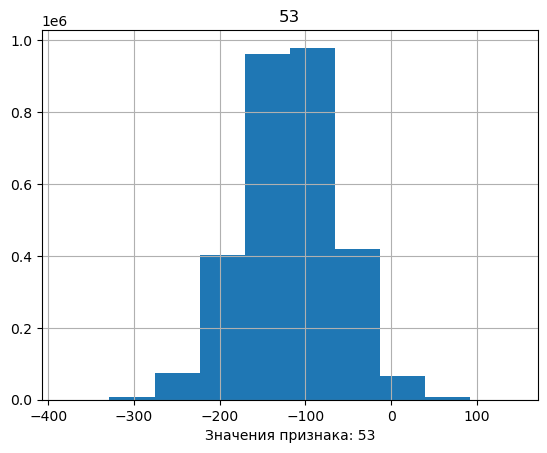

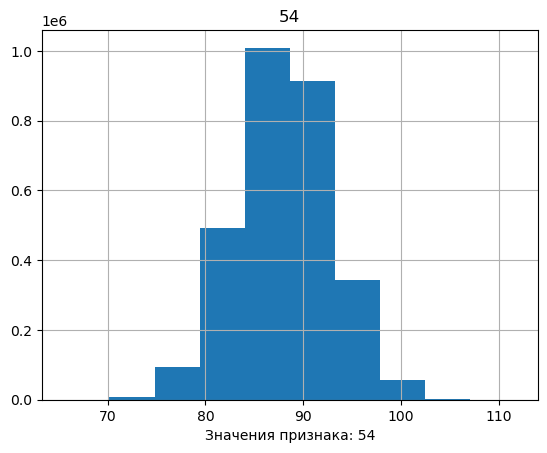

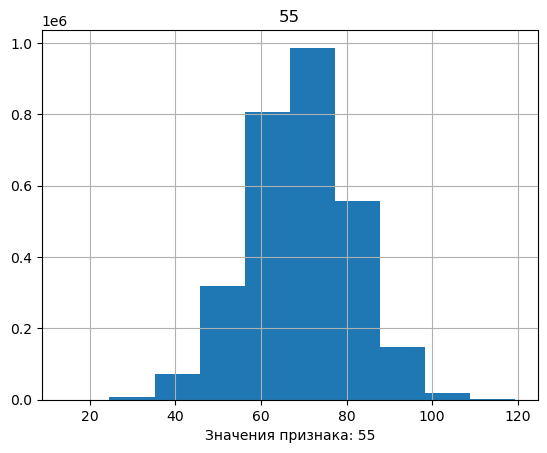

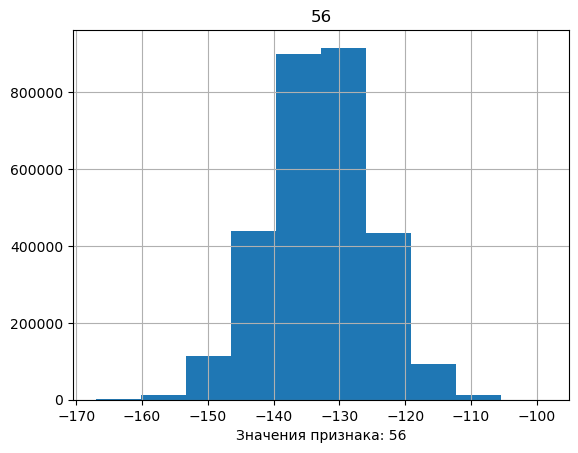

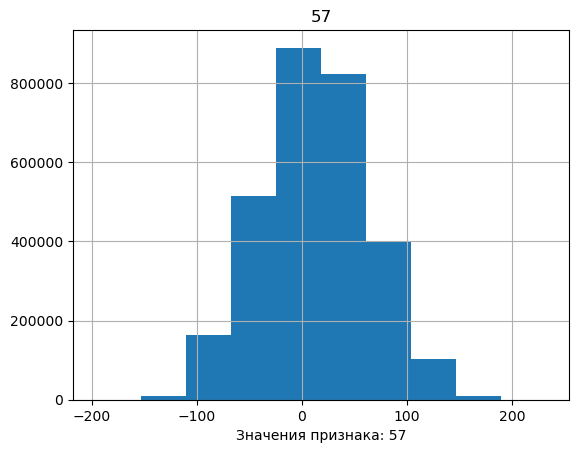

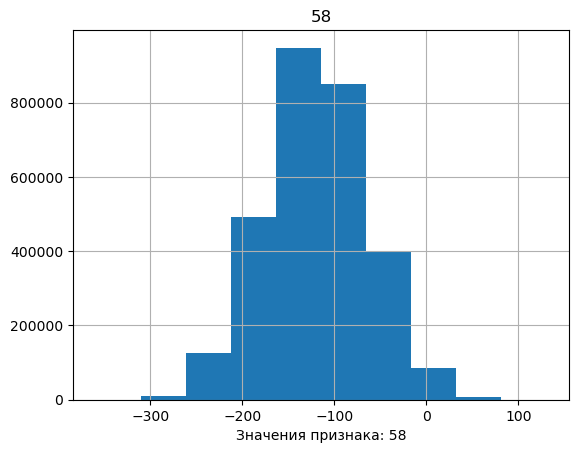

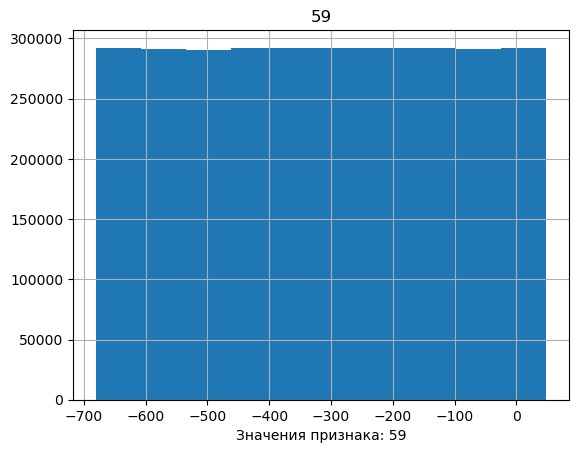

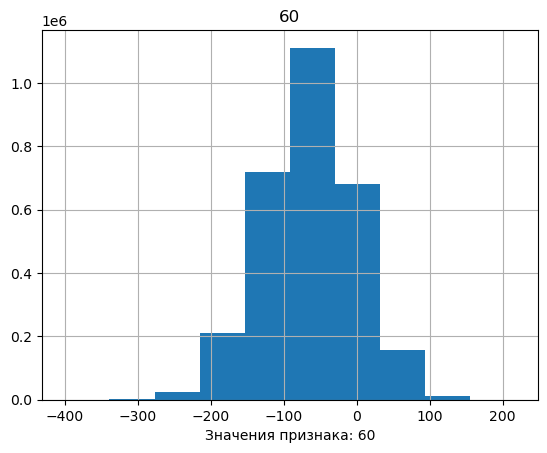

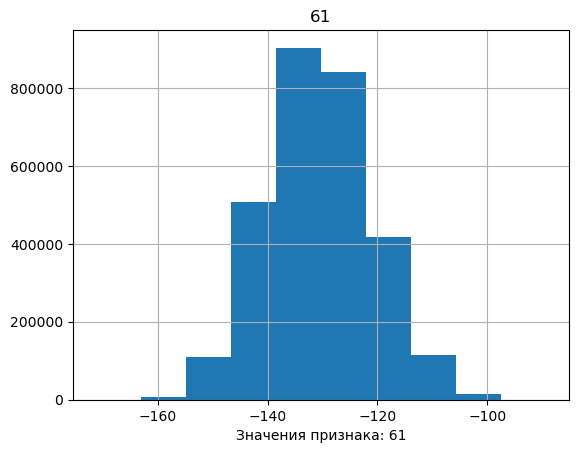

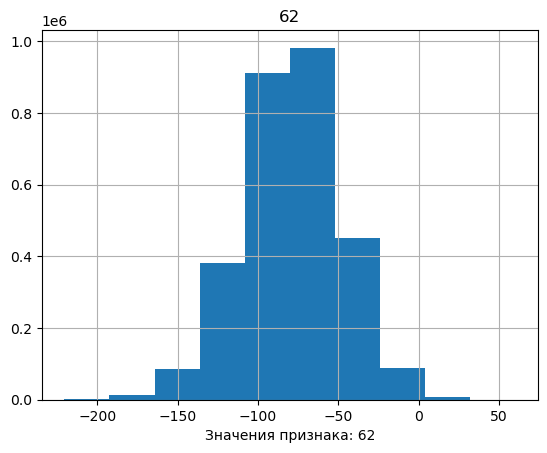

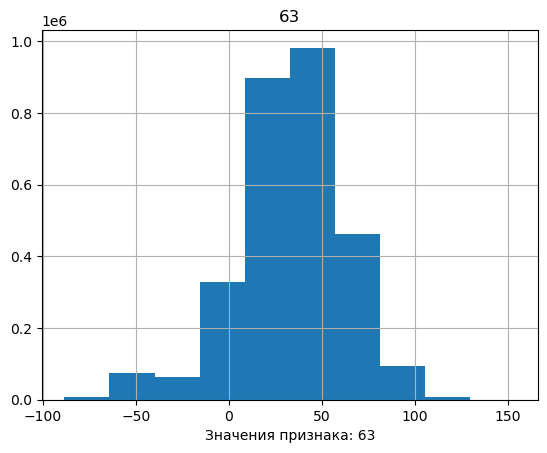

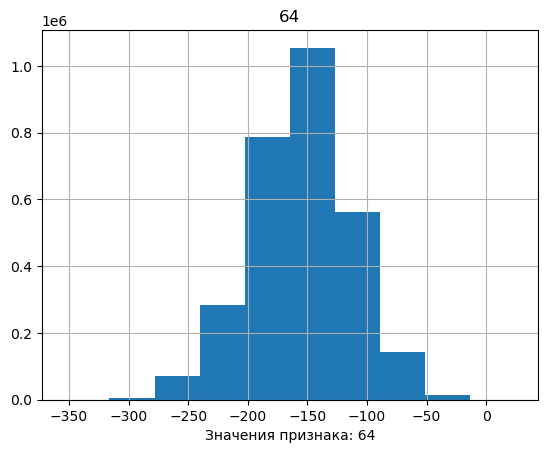

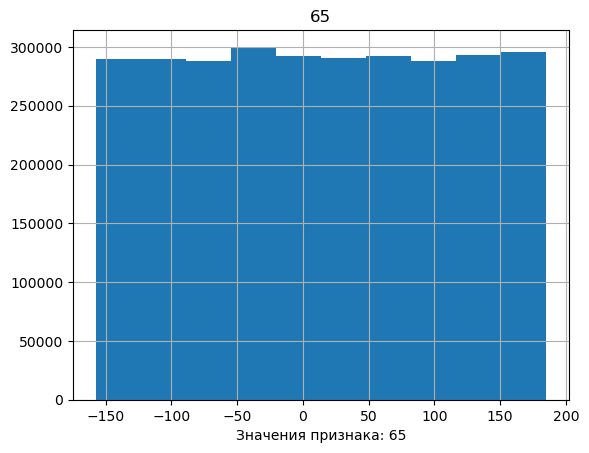

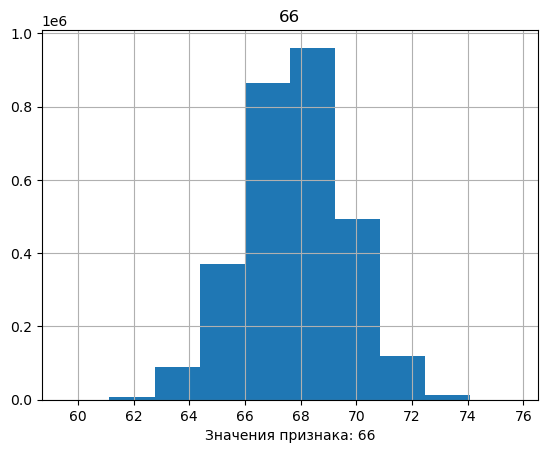

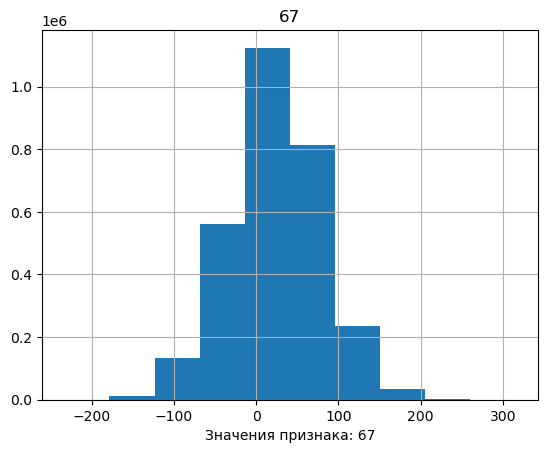

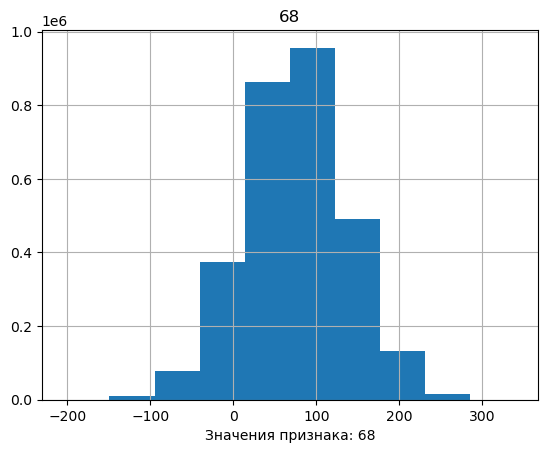

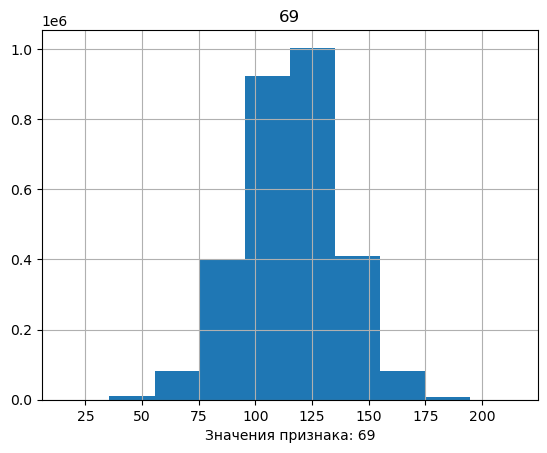

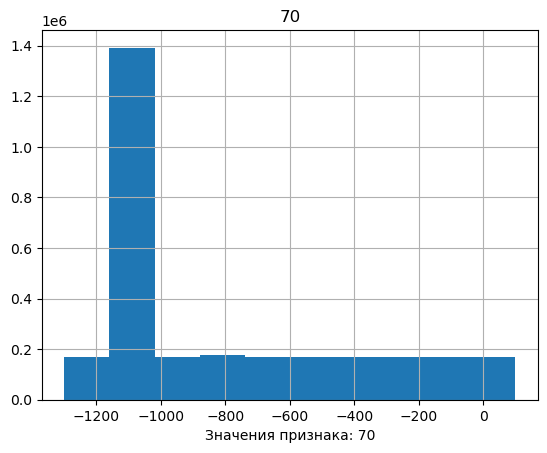

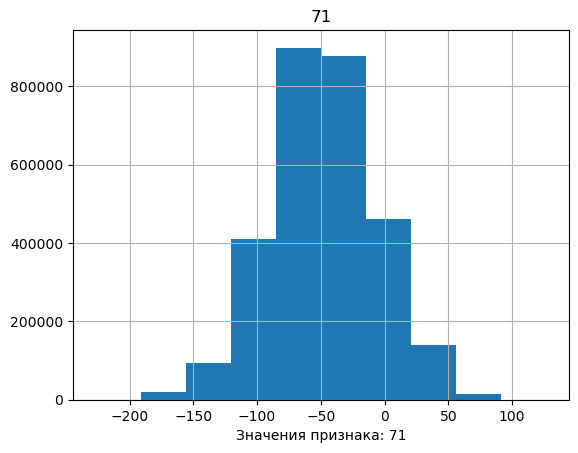

In [8]:
for column in df_base.columns:
    df_base[column].hist();
    plt.xlabel(f'Значения признака: {column}')
    plt.title(column)
    plt.show()

In [9]:
sns.set(rc={'figure.figsize':(100, 100)})

In [10]:
# тепловая карта корреляции признаков
sns.heatmap(df_base.corr(), annot=True);

In [11]:
# масштабирование данных
numeric = [*df_base.select_dtypes(exclude=['object']).columns]

scaler = StandardScaler()
scaler.fit(df_base[numeric])

df_base[numeric] = scaler.transform(df_base[numeric])

In [12]:
df_base.head()

0         1         2         3         4         5         6  \
Id                                                                             
0-base -1.159216  0.620350 -0.513723  1.398558  2.269043 -1.160385 -0.282884   
1-base  2.075715  1.060423 -0.652491 -1.002705 -1.157244 -0.500495  1.130652   
2-base  1.285417 -0.343342  0.397878  0.666228  0.853956 -0.973671  1.637293   
3-base -0.051852 -0.816047 -1.118829 -1.936660 -0.754014  0.461441  0.033281   
4-base  0.541780 -0.314538  2.284450  0.303705 -2.276181 -1.422075 -0.020200   

               7         8         9  ...        62        63        64  \
Id                                    ...                                 
0-base  0.373663 -0.435627  0.884544  ...  1.189049  0.190524  0.073589   
1-base -0.871900 -0.623903  1.098487  ... -1.272135  0.270119 -0.073569   
2-base  0.654489  0.828686  0.619635  ...  0.086191  0.440159 -1.269686   
3-base -0.840347 -0.259958  0.182763  ...  0.274980 -1.372853  0.184217   
4-base  0.386656 -0.238677 -0.191508  ...  0.716557  0.808178 -0.110496   

              65        66        67        68        69        70        71  
Id                                                                            
0-base -0.894789 -2.262493 -0.510438  0.293004 -0.014051  1.781420 -0.312329  
1-base -1.097493  0.225102  0.014491  1.711283  0.059848  1.853726 -0.281052  
2-base  1.143739 -1.220546  0.773022  0.099669  0.048521 -0.713847  0.365623  
3-base -0.523936 -0.871349 -0.797073  1.014714  0.090076 -0.713847 -0.601807  
4-base  0.725544 -0.562342 -0.470720 -0.157210  0.920175 -0.713847  1.152406  

[5 rows x 72 columns]

### Create index

In [13]:
dims = df_base.shape[1]
n_cells = 5
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [ ]:
# res = faiss.StandardGpuResources()
# idx_l2 = faiss.index_cpu_to_gpu(res, 0, idx_l2)

In [14]:
idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32'))

idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [15]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

#del df_base

## Train

In [16]:
# загрузка обучающего датасет
df_train = pd.read_csv("/kaggle/input/datama2/train.csv", index_col=0)
df_train.head()

0          1           2          3           4           5  \
Id                                                                             
0-query -53.882748  17.971436  -42.117104 -183.93668  187.517490  -87.144930   
1-query -87.776370   6.806268  -32.054546 -177.26039  120.803330  -83.810590   
2-query -49.979565   3.841486 -116.118590 -180.40198  190.128430  -50.837620   
3-query -47.810562   9.086598 -115.401695 -121.01136   94.652840 -109.255410   
4-query -79.632126  14.442886  -58.903397 -147.05254   57.127068  -16.239529   

                  6          7           8           9  ...         63  \
Id                                                      ...              
0-query -347.360606  38.307602  109.085560   30.413513  ...  70.107360   
1-query  -94.572749 -78.433090  124.915900  140.331070  ...   4.669178   
2-query   26.943937 -30.447489  125.771164  211.607820  ...  78.039764   
3-query -775.150134  79.186520  124.003100  242.650650  ...  44.515266   
4-query -321.317964  45.984676  125.941284  103.392670  ...  45.028910   

                64          65         66          67          68          69  \
Id                                                                              
0-query -155.80257 -101.965943  65.903790   34.457500   62.642094  134.763600   
1-query -151.69771   -1.638704  68.170876   25.096191   89.974976  130.589630   
2-query -169.14620   82.144186  66.008220   18.400496  212.409730  121.931470   
3-query -145.41675   93.990981  64.131350  106.061920   83.178760  118.277725   
4-query -196.09207 -117.626337  66.926220   42.456170   77.621765   92.479930   

                  70         71        Target  
Id                                             
0-query  -415.750254 -25.958572   675816-base  
1-query -1035.092211 -51.276833   366656-base  
2-query -1074.464888 -22.547178  1447819-base  
3-query -1074.464888 -19.902788  1472602-base  
4-query -1074.464888 -21.149351   717819-base  

[5 rows x 73 columns]

In [17]:
df_train.shape

(100000, 73)

In [18]:
# выделение целевого признака
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [19]:
# масштабирование данных
numeric = [*df_train.select_dtypes(exclude=['object']).columns]

df_train[numeric] = scaler.transform(df_train[numeric])

In [20]:
idx_l2.nprobe = 3

In [21]:
# поиск 20 ближайших соседей для векторов из df_train
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 20)

In [22]:
# проверка accuracy@20
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

71.832


In [23]:
# создание пустого DataFrame для хранения таргета
target_df = pd.DataFrame(columns=['vector_index', 'candidate_index', 'target'])

In [24]:
# создание таргета для обучения ранжирующей модели
for i in range(5000):
    vector_index = df_train.index[i]
    candidates = idx[i]

    for j, candidate_idx in enumerate(candidates):
        candidate_index = df_base.index[candidate_idx]

        if candidate_index in targets[vector_index]:
            target_df = pd.concat([target_df,
                                    pd.DataFrame({'vector_index': vector_index,
                                                'candidate_index': candidate_index,
                                                'target': 1}, index=[0])],
                                    ignore_index=True)
        else:
            target_df = pd.concat([target_df,
                                    pd.DataFrame({'vector_index': vector_index,
                                                    'candidate_index': candidate_index,
                                                    'target': 0}, index=[0])],
                                    ignore_index=True)

In [25]:
target_df.head(20)

vector_index candidate_index target
0       0-query     675816-base      1
1       0-query     877519-base      0
2       0-query     361564-base      0
3       0-query    2725256-base      0
4       0-query      13406-base      0
5       0-query    1408780-base      0
6       0-query     530165-base      0
7       0-query     656625-base      0
8       0-query    3543241-base      0
9       0-query     494555-base      0
10      0-query    1196008-base      0
11      0-query    2228287-base      0
12      0-query    2515747-base      0
13      0-query     558502-base      0
14      0-query    2192613-base      0
15      0-query      91611-base      0
16      0-query     148556-base      0
17      0-query    1192211-base      0
18      0-query     715085-base      0
19      0-query    3514999-base      0

In [26]:
target_df.shape

(100000, 3)

In [27]:
# соединение таргета и признаков из df_train
target_df = target_df.merge(df_train, how='inner', left_on='vector_index', right_index=True)

In [28]:
# соединение таргета и признаков из df_base
target_df = target_df.merge(df_base, how='inner', left_on='candidate_index', right_index=True)

In [29]:
target_df.head()

vector_index candidate_index target       0_x       1_x       2_x  \
0          0-query     675816-base      1  1.299519  1.996888  0.063774   
1          0-query     877519-base      0  1.299519  1.996888  0.063774   
18021    901-query     877519-base      0  1.916994  1.153344 -0.199909   
2          0-query     361564-base      0  1.299519  1.996888  0.063774   
18037    901-query     361564-base      0  1.916994  1.153344 -0.199909   

            3_x       4_x       5_x       6_x  ...      62_y      63_y  \
0     -1.879671  1.644100 -0.537626  0.165148  ... -0.927103  1.627806   
1     -1.879671  1.644100 -0.537626  0.165148  ... -0.676032  1.615281   
18021 -1.319427 -0.193553 -0.269549 -1.287975  ... -0.676032  1.615281   
2     -1.879671  1.644100 -0.537626  0.165148  ... -0.332150  1.723392   
18037 -1.319427 -0.193553 -0.269549 -1.287975  ... -0.332150  1.723392   

           64_y      65_y      66_y      67_y      68_y      69_y      70_y  \
0      0.072924  0.427460 -0.496641  0.394758 -0.568302  0.066837  0.995267   
1     -0.247046 -0.404396 -1.148503  0.412697 -0.375744  0.728224  0.544932   
18021 -0.247046 -0.404396 -1.148503  0.412697 -0.375744  0.728224  0.544932   
2     -0.369458  0.988497 -1.100241  0.280916 -0.492041  0.532096  0.543575   
18037 -0.369458  0.988497 -1.100241  0.280916 -0.492041  0.532096  0.543575   

           71_y  
0      0.708902  
1      0.270560  
18021  0.270560  
2      0.090279  
18037  0.090279  

[5 rows x 147 columns]

In [30]:
target_df.shape

(100000, 147)

In [31]:
# удаление неинформативных признаков
target_df_cb = target_df.drop(['vector_index', 'candidate_index'], axis=1)

In [32]:
target_df_cb.head()

target       0_x       1_x       2_x       3_x       4_x       5_x  \
0          1  1.299519  1.996888  0.063774 -1.879671  1.644100 -0.537626   
1          0  1.299519  1.996888  0.063774 -1.879671  1.644100 -0.537626   
18021      0  1.916994  1.153344 -0.199909 -1.319427 -0.193553 -0.269549   
2          0  1.299519  1.996888  0.063774 -1.879671  1.644100 -0.537626   
18037      0  1.916994  1.153344 -0.199909 -1.319427 -0.193553 -0.269549   

            6_x       7_x       8_x  ...      62_y      63_y      64_y  \
0      0.165148  0.279598 -2.296794  ... -0.927103  1.627806  0.072924   
1      0.165148  0.279598 -2.296794  ... -0.676032  1.615281 -0.247046   
18021 -1.287975  0.345101 -0.892164  ... -0.676032  1.615281 -0.247046   
2      0.165148  0.279598 -2.296794  ... -0.332150  1.723392 -0.369458   
18037 -1.287975  0.345101 -0.892164  ... -0.332150  1.723392 -0.369458   

           65_y      66_y      67_y      68_y      69_y      70_y      71_y  
0      0.427460 -0.496641  0.394758 -0.568302  0.066837  0.995267  0.708902  
1     -0.404396 -1.148503  0.412697 -0.375744  0.728224  0.544932  0.270560  
18021 -0.404396 -1.148503  0.412697 -0.375744  0.728224  0.544932  0.270560  
2      0.988497 -1.100241  0.280916 -0.492041  0.532096  0.543575  0.090279  
18037  0.988497 -1.100241  0.280916 -0.492041  0.532096  0.543575  0.090279  

[5 rows x 145 columns]

### Обучение  CatBoostClassifier

In [33]:
# выделение целевого признака
features = target_df_cb.drop('target', axis=1)
target = target_df_cb['target']

In [34]:
target = target.astype('int')

In [35]:
# создание обучающей и тестовой выборок
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=random_state)

In [36]:
# обучение CatBoostClassifier
cat = CatBoostClassifier()

cat.fit(features_train, target_train)
predictions = cat.predict(features_test)

Learning rate set to 0.065101
0:	learn: 0.5999235	total: 127ms	remaining: 2m 7s
1:	learn: 0.5229667	total: 195ms	remaining: 1m 37s
2:	learn: 0.4597417	total: 254ms	remaining: 1m 24s
3:	learn: 0.4077538	total: 315ms	remaining: 1m 18s
4:	learn: 0.3651261	total: 370ms	remaining: 1m 13s
5:	learn: 0.3298814	total: 431ms	remaining: 1m 11s
6:	learn: 0.3011820	total: 480ms	remaining: 1m 8s
7:	learn: 0.2760007	total: 542ms	remaining: 1m 7s
8:	learn: 0.2566083	total: 606ms	remaining: 1m 6s
9:	learn: 0.2394670	total: 667ms	remaining: 1m 6s
10:	learn: 0.2259076	total: 733ms	remaining: 1m 5s
11:	learn: 0.2149265	total: 798ms	remaining: 1m 5s
12:	learn: 0.2057745	total: 855ms	remaining: 1m 4s
13:	learn: 0.1975678	total: 915ms	remaining: 1m 4s
14:	learn: 0.1904748	total: 975ms	remaining: 1m 4s
15:	learn: 0.1851978	total: 1.03s	remaining: 1m 3s
16:	learn: 0.1803856	total: 1.08s	remaining: 1m 2s
17:	learn: 0.1764786	total: 1.14s	remaining: 1m 2s
18:	learn: 0.1723450	total: 1.2s	remaining: 1m 2s
19:	lea

In [37]:
print(f'Accuracy: {accuracy_score(target_test, predictions)}')

Accuracy: 0.9796


# Проверка модели на валидационных данных

In [38]:
# загрузка валидационного датасета
valid_data = pd.read_csv("/kaggle/input/data-valid/validation.csv", index_col=0)
valid_data.head()

0          1          2          3          4  \
Id                                                                    
100000-query -57.372734   3.597752 -13.213642 -125.92679  110.74594   
100001-query -53.758705  12.790300 -43.268543 -134.41762  114.44991   
100002-query -64.175095  -3.980927  -7.679249 -170.16093   96.44616   
100003-query -99.286860  16.123936   9.837166 -148.06044   83.69708   
100004-query -79.532920  -0.364173 -16.027431 -170.88495  165.45392   

                       5           6           7           8           9  ...  \
Id                                                                        ...   
100000-query  -81.279594 -461.003172  139.815720  112.880980   75.215750  ...   
100001-query  -90.520130 -759.626065   63.995087  127.117905   53.128998  ...   
100002-query  -62.377740 -759.626065   87.477554  131.270110  168.920320  ...   
100003-query -133.729720   58.576403  -19.046660  115.042404   75.206730  ...   
100004-query  -28.291668   33.931936   34.411217  128.903980  102.086914  ...   

                     62         63         64          65        66  \
Id                                                                    
100000-query  -75.51302  52.830902 -143.43945   59.051935  69.28224   
100001-query  -79.44183  29.185436 -168.60590  -82.872443  70.76560   
100002-query -134.79541  37.368730 -159.66231 -119.232725  67.71044   
100003-query  -77.23611  44.100494 -132.53012 -106.318982  70.88396   
100004-query -123.77025  45.635944 -134.25893   13.735359  70.61763   

                     67         68          69           70          71  
Id                                                                       
100000-query  61.927513  111.59253  115.140656 -1099.130485 -117.079360  
100001-query -65.975950   97.07716  123.391640  -744.442332  -25.009320  
100002-query  86.002060  137.63641  141.081630  -294.052271  -70.969604  
100003-query  23.577892  133.18396  143.252940  -799.363667  -89.392670  
100004-query  15.332115  154.56812  101.700640 -1171.892332 -125.307890  

[5 rows x 72 columns]

In [39]:
valid_data.shape

(100000, 72)

In [41]:
# загрузка ответов для валидационного датасета
target_valid = pd.read_csv("/kaggle/input/data-valid/validation_answer.csv", index_col=0)

In [42]:
# масштабирование данных
numeric = [*valid_data.select_dtypes(exclude=['object']).columns]

valid_data[numeric] = scaler.transform(valid_data[numeric])

## FAISS

In [43]:
vecs, idx = idx_l2.search(np.ascontiguousarray(valid_data.values).astype('float32'), 5)

In [44]:
# проверка accuracy@5 для валидационного датасета
acc = 0
for target, el in zip(target_valid.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

0.0


In [45]:
# создание пустого DataFrame для хранения таргета
target_valid_df = pd.DataFrame(columns=['vector_index', 'candidate_index', 'target'])

In [59]:
# создание таргета для обучения ранжирующей модели
for i in range(20000):
    vector_index = valid_data.index[i]
    candidates = idx[i]

    for j, candidate_idx in enumerate(candidates):
        candidate_index = df_base.index[candidate_idx]

        if candidate_index in target_valid.loc[vector_index]:
            target_valid_df = pd.concat([target_valid_df,
                                         pd.DataFrame({'vector_index': vector_index,
                                                       'candidate_index': candidate_index,
                                                       'target': 1}, index=[0])],
                                        ignore_index=True)
        else:
            target_valid_df = pd.concat([target_valid_df,
                                         pd.DataFrame({'vector_index': vector_index,
                                                       'candidate_index': candidate_index,
                                                       'target': 0}, index=[0])],
                                        ignore_index=True)

In [67]:
target_valid_df

vector_index candidate_index target
0      100000-query    3209652-base      0
1      100000-query    3181043-base      0
2      100000-query     368296-base      0
3      100000-query     645855-base      0
4      100000-query    2760762-base      0
...             ...             ...    ...
99995  119999-query     593344-base      0
99996  119999-query     675520-base      0
99997  119999-query     561833-base      0
99998  119999-query     157459-base      0
99999  119999-query     265741-base      0

[100000 rows x 3 columns]

In [68]:
# соединение таргета и признаков из df_train и df_base
target_valid = target_valid_df.merge(valid_data, how='inner', left_on='vector_index', right_index=True)
target_valid = target_valid.merge(df_base, how='inner', left_on='candidate_index', right_index=True)

In [69]:
target_valid

vector_index candidate_index target       0_x       1_x       2_x  \
0      100000-query    3209652-base      0  1.159310 -0.904901  0.811955   
1      100000-query    3181043-base      0  1.159310 -0.904901  0.811955   
2      100000-query     368296-base      0  1.159310 -0.904901  0.811955   
3      100000-query     645855-base      0  1.159310 -0.904901  0.811955   
4      100000-query    2760762-base      0  1.159310 -0.904901  0.811955   
...             ...             ...    ...       ...       ...       ...   
99992  119998-query    1800539-base      0  0.376706 -0.656242 -1.757968   
99993  119998-query    4132737-base      0  0.376706 -0.656242 -1.757968   
99994  119998-query    3025686-base      0  0.376706 -0.656242 -1.757968   
99995  119999-query     593344-base      0  0.277091  0.932180 -1.323345   
99997  119999-query     561833-base      0  0.277091  0.932180 -1.323345   

            3_x       4_x       5_x       6_x  ...      62_y      63_y  \
0      1.043508 -0.012313 -0.329532 -0.253186  ...  0.457506  0.948873   
1      1.043508 -0.012313 -0.329532 -0.253186  ...  0.190811  0.477240   
2      1.043508 -0.012313 -0.329532 -0.253186  ... -0.228085  0.011799   
3      1.043508 -0.012313 -0.329532 -0.253186  ...  0.062169  0.174387   
4      1.043508 -0.012313 -0.329532 -0.253186  ... -0.061286  0.089266   
...         ...       ...       ...       ...  ...       ...       ...   
99992 -0.290404  1.615630 -0.551941 -1.352459  ... -0.780573 -0.918749   
99993 -0.290404  1.615630 -0.551941 -1.352459  ... -1.256971 -1.349280   
99994 -0.290404  1.615630 -0.551941 -1.352459  ... -1.115238 -0.103663   
99995  0.062908 -1.959352  1.131468 -1.352459  ...  0.459877  0.098417   
99997  0.062908 -1.959352  1.131468 -1.352459  ...  0.295853  0.166558   

           64_y      65_y      66_y      67_y      68_y      69_y      70_y  \
0      0.570802  1.213205  0.909867  0.897679  0.018913  0.430446 -0.713847   
1     -0.017377  0.170011  0.557127  0.766064  0.048265  0.406469 -0.713847   
2      0.883902  1.235784  0.495694  0.563696  0.170485 -0.324675 -1.051440   
3      0.044383  0.015341 -0.042959  0.317641  0.067884  0.540182 -0.713847   
4      0.047589  0.222569  0.533942  1.168393 -0.104937  0.162421 -0.005964   
...         ...       ...       ...       ...       ...       ...       ...   
99992  1.129227 -1.530323 -0.717468  0.488220  0.247744 -0.581665 -0.713847   
99993  0.925436 -0.140762  0.692500 -0.145644 -0.855948  0.157704 -0.713847   
99994  0.384631 -0.847381 -0.558536 -0.082860 -0.482937 -0.065797 -0.713847   
99995  1.054828  0.577555  1.001988  0.606139 -0.344263 -0.396912 -0.642125   
99997  1.762033  1.595975  0.570794  0.783048  0.088815 -0.074666 -0.196208   

           71_y  
0     -1.182590  
1     -1.284064  
2     -1.097352  
3     -1.343913  
4     -1.245106  
...         ...  
99992  1.169584  
99993  0.181148  
99994  0.247784  
99995  0.788584  
99997  1.614474  

[100000 rows x 147 columns]

In [70]:
# удаление неинформативных признаков
target_valid_cb = target_valid.drop(['vector_index', 'candidate_index'], axis=1)

In [75]:
target_valid_cb

target       0_x       1_x       2_x       3_x       4_x       5_x  \
0          0  1.159310 -0.904901  0.811955  1.043508 -0.012313 -0.329532   
1          0  1.159310 -0.904901  0.811955  1.043508 -0.012313 -0.329532   
2          0  1.159310 -0.904901  0.811955  1.043508 -0.012313 -0.329532   
3          0  1.159310 -0.904901  0.811955  1.043508 -0.012313 -0.329532   
4          0  1.159310 -0.904901  0.811955  1.043508 -0.012313 -0.329532   
...      ...       ...       ...       ...       ...       ...       ...   
99992      0  0.376706 -0.656242 -1.757968 -0.290404  1.615630 -0.551941   
99993      0  0.376706 -0.656242 -1.757968 -0.290404  1.615630 -0.551941   
99994      0  0.376706 -0.656242 -1.757968 -0.290404  1.615630 -0.551941   
99995      0  0.277091  0.932180 -1.323345  0.062908 -1.959352  1.131468   
99997      0  0.277091  0.932180 -1.323345  0.062908 -1.959352  1.131468   

            6_x       7_x       8_x  ...      62_y      63_y      64_y  \
0     -0.253186  1.860318 -1.699665  ...  0.457506  0.948873  0.570802   
1     -0.253186  1.860318 -1.699665  ...  0.190811  0.477240 -0.017377   
2     -0.253186  1.860318 -1.699665  ... -0.228085  0.011799  0.883902   
3     -0.253186  1.860318 -1.699665  ...  0.062169  0.174387  0.044383   
4     -0.253186  1.860318 -1.699665  ... -0.061286  0.089266  0.047589   
...         ...       ...       ...  ...       ...       ...       ...   
99992 -1.352459  0.474078  1.094677  ... -0.780573 -0.918749  1.129227   
99993 -1.352459  0.474078  1.094677  ... -1.256971 -1.349280  0.925436   
99994 -1.352459  0.474078  1.094677  ... -1.115238 -0.103663  0.384631   
99995 -1.352459  0.573327  1.984733  ...  0.459877  0.098417  1.054828   
99997 -1.352459  0.573327  1.984733  ...  0.295853  0.166558  1.762033   

           65_y      66_y      67_y      68_y      69_y      70_y      71_y  
0      1.213205  0.909867  0.897679  0.018913  0.430446 -0.713847 -1.182590  
1      0.170011  0.557127  0.766064  0.048265  0.406469 -0.713847 -1.284064  
2      1.235784  0.495694  0.563696  0.170485 -0.324675 -1.051440 -1.097352  
3      0.015341 -0.042959  0.317641  0.067884  0.540182 -0.713847 -1.343913  
4      0.222569  0.533942  1.168393 -0.104937  0.162421 -0.005964 -1.245106  
...         ...       ...       ...       ...       ...       ...       ...  
99992 -1.530323 -0.717468  0.488220  0.247744 -0.581665 -0.713847  1.169584  
99993 -0.140762  0.692500 -0.145644 -0.855948  0.157704 -0.713847  0.181148  
99994 -0.847381 -0.558536 -0.082860 -0.482937 -0.065797 -0.713847  0.247784  
99995  0.577555  1.001988  0.606139 -0.344263 -0.396912 -0.642125  0.788584  
99997  1.595975  0.570794  0.783048  0.088815 -0.074666 -0.196208  1.614474  

[100000 rows x 145 columns]

## CatBoost

In [76]:
# выделение таргета
features_val = target_valid_cb.drop('target', axis=1)
target_val = target_valid_cb['target']

In [77]:
target_val = target_val.astype('int')

In [78]:
# проврека accuracy на валидационных данных
predictions_valid = cat.predict(features_val)

In [79]:
print(f'Accuracy: {accuracy_score(target_val, predictions_valid)}')

Accuracy: 0.9251
